In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import roc_auc_score,classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_plot,pdp_isolate 

In [2]:
#Loading the supreme court database
#data = pd.read_csv('data/SCDB_2018_02_caseCentered_Citation.csv',encoding='ISO 8859-1')
data = pd.read_csv('../data/SCDB_2019_01_caseCentered_Citation.csv',encoding='ISO 8859-1')
data.shape

(8966, 53)

In [20]:
#if AdminAction value is 117 in AdminAction if the action has been taken by State Agency
#creating this variables before normalising null values
data['is_adminAction'] = data['adminAction'].notna().astype(int)
data['is_adminActionState']=data['adminActionState'].notna().astype(int)
data['case_argued']=(data['dateArgument'].notna()).astype(int)
data['case_reargued']=(data['dateRearg'].notna()).astype(int)

In [8]:
data['case_reargued'].value_counts()

0    8788
1     178
Name: case_reargued, dtype: int64

In [9]:
data['case_argued'].value_counts()

1    7926
0    1040
Name: case_argued, dtype: int64

In [10]:
#Selecting all float columns, they should have been int cols, due to Null values they are designated as Float columns
float_columns = data.select_dtypes('float64').columns
#Replacing all null values with 9999 to convert the float columns to Int
data[float_columns] = data[float_columns].fillna(-1)
for col in float_columns:
    data[col] = data[col].astype('int')


In [11]:
court_dict = {
    
        -1: 'Not Applicable',
        48: 'California Central U.S. District Court',
        50: 'California Northern U.S. District Court',
        51: 'California Southern U.S. District Court',
        55: 'District Of Columbia U.S. District Court',
        58: 'Florida Southern U.S. District Court',
        66: 'Illinois Northern U.S. District Court',
        75: 'Louisiana Eastern U.S. District Court',
        80: 'Massachusetts U.S. District Court',
        81: 'Michigan Eastern U.S. District Court',
        92: 'New Jersey U.S. District Court',
        94: 'New York Eastern U.S. District Court',
        96: 'New York Southern U.S. District Court',
        109: 'Pennsylvania Eastern U.S. District Court',
        301: 'State Appellate Court',
        300: 'State Supreme Court',
        302: 'State Trial Court',
        121: 'Texas Southern U.S. District Court',
        32: 'U.S. Court of Appeals, District of Columbia',
        28: 'U.S. Court of Appeals, Eighth Circuit',
        31: 'U.S. Court of Appeals, Eleventh Circuit',
        8: 'U.S. Court of Appeals, Federal Circuit',
        25: 'U.S. Court of Appeals, Fifth Circuit',
        21: 'U.S. Court of Appeals, First Circuit',
        24: 'U.S. Court of Appeals, Fourth Circuit',
        29: 'U.S. Court of Appeals, Ninth Circuit',
        22: 'U.S. Court of Appeals, Second Circuit',
        27: 'U.S. Court of Appeals, Seventh Circuit',
        26: 'U.S. Court of Appeals, Sixth Circuit',
        30: 'U.S. Court of Appeals, Tenth Circuit',
        23: 'U.S. Court of Appeals, Third Circuit',
        3: 'U.S. Court of Claims, Court of Federal Claims',
        9: 'U.S. Tax Court',
        126: 'Virginia Eastern U.S. District Court',
        9999:'Other Courts'
                                }

In [12]:
#updatining caseOrigin with court dict values, other values will be replaced with 9999
data['caseOrigin']=data['caseOrigin'].apply(lambda x: x if x in court_dict.keys() else 9999)
#updatining caseSource with court dict values, other values will be replaced with 9999
data['caseSource']=data['caseSource'].apply(lambda x: x if x in court_dict.keys() else 9999)

In [13]:
#updatining petitioner with top 15 values, other values will be replaced with 9999
petition_category = data['petitioner'].value_counts(ascending=False)[:15].index.values
data['petitioner']=data['petitioner'].apply(lambda x: x if x in petition_category else 9999)
#updatining respondent with top 15 values, other values will be replaced with 9999
respondent_category = data['respondent'].value_counts(ascending=False)[:15].index.values
data['respondent']=data['respondent'].apply(lambda x: x if x in petition_category else 9999)

In [14]:
#Separating the variables based on data from the codebook
identity_variables = ['caseId', 'docketId', 'caseIssuesId', 'voteId', 'usCite','sctCite', 'ledCite',
                      'lexisCite', 'docket','caseName']

#Removing following variable from background
#adminAction and  adminActionState, being replaced with boolean features 
background_variables=['petitioner', 'petitionerState', 'respondent', 'respondentState','jurisdiction', 
                      'threeJudgeFdc', 'caseOrigin', 'caseOriginState',
                      'caseSource', 'caseSourceState','lcDisagreement', 'certReason', 'lcDisposition','issueArea']

outcome_variables = ['decisionType','declarationUncon','caseDisposition','caseDispositionUnusual',
                     'precedentAlteration','partyWinning']
vote_variables =['voteUnclear','majVotes','minVotes']

In [15]:
#Conveting date columns to date format
date_columns = ['dateArgument','dateRearg','dateDecision']
for col in date_columns:
    data[col]=pd.to_datetime(data[col],errors='coerce')

In [ ]:
parties_labels = {9999: 'Others',
                 28: 'State',
                 27: 'United States',
                 100: 'Person accused of crime',
                 126: 'Person convicted of crime',
                 19: 'Govt Official',
                 145: 'Employee',
                 151: 'Employer',
                 249: 'Union',
                 8: 'Govt Employee',
                 3: 'City,Town or Govt Unit',
                 106: 'Alien',
                 215: 'Prisoner',
                 382: 'Labor Board',
                 195: 'Owner',
                 240: 'Taxpayer'}

In [ ]:
    lc_disposition_dict={1:'stay, petition, or motion granted',
                            2:'affirmed',
                            3:'reversed',
                            4:'reversed and remanded',
                            5:'vacated and remanded',
                            6:'affirmed and reversed (or vacated) in part',
                            7:'affirmed and reversed (or vacated) in part and remanded',
                            8:'vacated',
                            9:'petition denied or appeal dismissed',
                            10:'modify',
                            11:'remand',
                            12:'unusual disposition'}

In [ ]:
cert_labels_dict={1: 'case did not arise on cert or cert not granted',
 2: 'federal court conflict',
 3: 'federal court conflict and to resolve important or significant question',
 4: 'putative conflict',
 5: 'conflict between federal court and state court',
 6: 'state court conflict',
 7: 'federal court confusion or uncertainty',
 8: 'state court confusion or uncertainty',
 9: 'federal court and state court confusion or uncertainty',
 10: 'to resolve important or significant question',
 11: 'to resolve question presented',
 12: 'no reason given',
 13: 'other reason'}

In [ ]:
jurisdiction_dict = {1: 'cert',
                    2: 'appeal',
                    3: 'bail',
                    4: 'certification',
                    5: 'docketing fee',
                    6: 'rehearing or restored to calendar for reargument',
                    7: 'injunction',
                    8: 'mandamus',
                    9: 'original',
                    10: 'prohibition',
                    12: 'stay',
                    13: 'writ of error',
                    14: 'writ of habeas corpus',
                    15: 'unspecified, other'    
}

In [16]:
#Sorting the data based on decisiondate - Useful for generating features
data = data.sort_values('dateDecision').reset_index(drop=True)

In [17]:
#Removing unspecified  and decisions with null valuesfrom the database
data = data[data['partyWinning'].isin([0,1])]
data.shape
#19 rows have been removed

(8947, 57)

In [18]:
#majority class base prediction is
data['partyWinning'].value_counts(normalize=True)
#64% is base line prediction

1    0.639656
0    0.360344
Name: partyWinning, dtype: float64

In [19]:
#Getting the ROC value for baseline prediction
y_pred = np.ones(len(data))
y_true = data['partyWinning'].values
roc_auc_score(y_true,y_pred)

0.5

In [21]:
#new_features = ['case_argued','case_reargued','is_adminAction','is_adminActionState','argued_since','reargued_since']
new_features = ['case_argued','case_reargued','is_adminAction','is_adminActionState']

In [ ]:

# prev_vote_variables = ['prev_'+item for item in vote_variables]
# prev_outcome_variables = ['prev_'+item for item in outcome_variables]
# #From previous same issue what was the decision and voting data 
# data[prev_vote_variables] = data.groupby('issueArea')[vote_variables].shift(1)
# data[prev_outcome_variables] = data.groupby('issueArea')[outcome_variables].shift(1)
#data['prev_votes']=data['prev_majVotes']+data['prev_minVotes']

In [ ]:
data['argued_since'] = (data['dateDecision']-data['dateArgument']).dt.days
data['reargued_since'] = (data['dateDecision']-data['dateRearg']).dt.days


In [ ]:
data['argued_since'].hist()

In [ ]:
def arguedays(row):
    if(row['dateArgument'] !=None):
        return (row['dateDecision']-row['dateArgument'])
    else:
       return 0

In [ ]:
data.apply(arguedays,axis=1).describe()

In [ ]:
data['reargued_since'].describe()

In [ ]:
pd.qcut(data['argued_since'],5,labels=[1,2,3,4,5])

In [ ]:
data = data.fillna(-1)

In [ ]:
data['argued_since']=pd.qcut(data['argued_since'],5,labels=[1,2,3,4,5],duplicates='drop')
#data['reargued_since']=pd.qcut(data['reargued_since'],5,labels=[1,2,3,4],duplicates='drop')

In [22]:
#Setting a basic model to fit the data
target = 'partyWinning'
features = background_variables+new_features

In [23]:
testsize = 1000
test = data[-testsize:]
val = data[-testsize*2:-testsize]
train = data[:-testsize*2]
test.shape,val.shape,train.shape

((1000, 57), (1000, 57), (6947, 57))

In [24]:
train[target].value_counts(normalize=True),val[target].value_counts(normalize=True),test[target].value_counts(normalize=True)

(1    0.63495
 0    0.36505
 Name: partyWinning, dtype: float64, 1    0.635
 0    0.365
 Name: partyWinning, dtype: float64, 1    0.677
 0    0.323
 Name: partyWinning, dtype: float64)

In [25]:
train = train.fillna(-1)
test = test.fillna(-1)
val = val.fillna(-1)


In [26]:
X_test = test[features]
y_test = test[target]
X_val = val[features]
y_val = val[target]
X_train = train[features]
y_train = train[target]

In [27]:
len(features)

18

In [28]:
rfc = RandomForestClassifier(n_estimators=1000,random_state=31,min_samples_split=5,max_depth=10)
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=31, verbose=0,
                       warm_start=False)

In [29]:

print("ROC score for Train is:",roc_auc_score(y_train,rfc.predict_proba(X_train)[:,1]))
print("ROC score for Val is:",roc_auc_score(y_val,rfc.predict_proba(X_val)[:,1]))
print("ROC score for Test is:",roc_auc_score(y_test,rfc.predict_proba(X_test)[:,1]))
print("Accuracy score for Train is:",accuracy_score(y_train,rfc.predict(X_train)))
print("Accuracy score for Val is:",accuracy_score(y_val,rfc.predict(X_val)))
print("Accuracy score for Test is:",accuracy_score(y_test,rfc.predict(X_test)))

ROC score for Train is: 0.8384142972794568
ROC score for Val is: 0.6662711681587747
ROC score for Test is: 0.6577232463381061
Accuracy score for Train is: 0.738448251043616
Accuracy score for Val is: 0.664
Accuracy score for Test is: 0.674


In [ ]:
# ROC score for Train is: 0.8763873671857065
# ROC score for Val is: 0.6722295329522165
# ROC score for Test is: 0.6508521934778732
# Accuracy score for Train is: 0.7475169137757305
# Accuracy score for Val is: 0.655
# Accuracy score for Test is: 0.672

# ROC score for Train is: 0.859208892738043
# ROC score for Val is: 0.6656455614281092
# ROC score for Test is: 0.6575563289142137
# Accuracy score for Train is: 0.742046926730963
# Accuracy score for Val is: 0.668
# Accuracy score for Test is: 0.669

In [30]:
from xgboost import XGBClassifier
xgboost = XGBClassifier(n_estimators=1000,learning_rate=0.02,objective='binary:logistic',max_depth=5,min_samples_split=5,random_state=31)
xgboost.fit(X_train,y_train,eval_metric='auc',eval_set=[(X_train,y_train),(X_val,y_val)],early_stopping_rounds=250)

[0]	validation_0-auc:0.651321	validation_1-auc:0.604761
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 250 rounds.
[1]	validation_0-auc:0.657806	validation_1-auc:0.622168
[2]	validation_0-auc:0.65672	validation_1-auc:0.614553
[3]	validation_0-auc:0.659329	validation_1-auc:0.622285
[4]	validation_0-auc:0.659471	validation_1-auc:0.622845
[5]	validation_0-auc:0.658991	validation_1-auc:0.625106
[6]	validation_0-auc:0.665899	validation_1-auc:0.628448
[7]	validation_0-auc:0.668878	validation_1-auc:0.633108
[8]	validation_0-auc:0.670571	validation_1-auc:0.634529
[9]	validation_0-auc:0.669926	validation_1-auc:0.63457
[10]	validation_0-auc:0.672371	validation_1-auc:0.63539
[11]	validation_0-auc:0.674886	validation_1-auc:0.636963
[12]	validation_0-auc:0.674115	validation_1-auc:0.636874
[13]	validation_0-auc:0.676516	validation_1-auc:0.640211
[14]	validation_0-auc:0.676441	validation_1-auc:0.640736


[141]	validation_0-auc:0.72934	validation_1-auc:0.655342
[142]	validation_0-auc:0.729719	validation_1-auc:0.655698
[143]	validation_0-auc:0.730169	validation_1-auc:0.655964
[144]	validation_0-auc:0.730213	validation_1-auc:0.656104
[145]	validation_0-auc:0.730457	validation_1-auc:0.656214
[146]	validation_0-auc:0.730793	validation_1-auc:0.656348
[147]	validation_0-auc:0.730986	validation_1-auc:0.656324
[148]	validation_0-auc:0.731005	validation_1-auc:0.656233
[149]	validation_0-auc:0.731425	validation_1-auc:0.656563
[150]	validation_0-auc:0.731837	validation_1-auc:0.656678
[151]	validation_0-auc:0.731918	validation_1-auc:0.656712
[152]	validation_0-auc:0.731936	validation_1-auc:0.656721
[153]	validation_0-auc:0.732484	validation_1-auc:0.656775
[154]	validation_0-auc:0.732794	validation_1-auc:0.656943
[155]	validation_0-auc:0.732868	validation_1-auc:0.657081
[156]	validation_0-auc:0.733184	validation_1-auc:0.657513
[157]	validation_0-auc:0.73341	validation_1-auc:0.65769
[158]	validation_

[283]	validation_0-auc:0.761405	validation_1-auc:0.659646
[284]	validation_0-auc:0.761655	validation_1-auc:0.659357
[285]	validation_0-auc:0.761726	validation_1-auc:0.659241
[286]	validation_0-auc:0.761917	validation_1-auc:0.659059
[287]	validation_0-auc:0.762037	validation_1-auc:0.659098
[288]	validation_0-auc:0.762492	validation_1-auc:0.658977
[289]	validation_0-auc:0.76264	validation_1-auc:0.658883
[290]	validation_0-auc:0.76268	validation_1-auc:0.658723
[291]	validation_0-auc:0.763091	validation_1-auc:0.658632
[292]	validation_0-auc:0.76347	validation_1-auc:0.658637
[293]	validation_0-auc:0.763655	validation_1-auc:0.658611
[294]	validation_0-auc:0.763731	validation_1-auc:0.658563
[295]	validation_0-auc:0.763864	validation_1-auc:0.658442
[296]	validation_0-auc:0.763895	validation_1-auc:0.658369
[297]	validation_0-auc:0.764025	validation_1-auc:0.658283
[298]	validation_0-auc:0.764131	validation_1-auc:0.658296
[299]	validation_0-auc:0.764224	validation_1-auc:0.658395
[300]	validation_

[425]	validation_0-auc:0.783116	validation_1-auc:0.658168
[426]	validation_0-auc:0.783241	validation_1-auc:0.658203
[427]	validation_0-auc:0.783421	validation_1-auc:0.658056
[428]	validation_0-auc:0.783553	validation_1-auc:0.658022
[429]	validation_0-auc:0.783723	validation_1-auc:0.65791
[430]	validation_0-auc:0.783888	validation_1-auc:0.657966
[431]	validation_0-auc:0.783997	validation_1-auc:0.657957
[432]	validation_0-auc:0.784131	validation_1-auc:0.657983
[433]	validation_0-auc:0.784227	validation_1-auc:0.658026
[434]	validation_0-auc:0.784433	validation_1-auc:0.657979
[435]	validation_0-auc:0.784744	validation_1-auc:0.658121
[436]	validation_0-auc:0.785051	validation_1-auc:0.657862
[437]	validation_0-auc:0.785074	validation_1-auc:0.657832
[438]	validation_0-auc:0.785141	validation_1-auc:0.657879
[439]	validation_0-auc:0.785438	validation_1-auc:0.657759
[440]	validation_0-auc:0.785564	validation_1-auc:0.657789
[441]	validation_0-auc:0.785663	validation_1-auc:0.657879
[442]	validatio

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=1, min_samples_split=5, missing=None,
              n_estimators=1000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=31, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [31]:
print("ROC score for Train is:",roc_auc_score(y_train,xgboost.predict_proba(X_train)[:,1]))
print("ROC score for Val is:",roc_auc_score(y_val,xgboost.predict_proba(X_val)[:,1]))
print("ROC score for Test is:",roc_auc_score(y_test,xgboost.predict_proba(X_test)[:,1]))
print("Accuracy score for Train is:",accuracy_score(y_train,xgboost.predict(X_train)))
print("Accuracy score for Val is:",accuracy_score(y_val,xgboost.predict(X_val)))
print("Accuracy score for Test is:",accuracy_score(y_test,xgboost.predict(X_test)))

ROC score for Train is: 0.7550812619297755
ROC score for Val is: 0.6610635314421314
ROC score for Test is: 0.6574077038107476
Accuracy score for Train is: 0.7001583417302433
Accuracy score for Val is: 0.668
Accuracy score for Test is: 0.665


In [ ]:
# ROC score for Train is: 0.7758706277752707
# ROC score for Val is: 0.659393808650631
# ROC score for Test is: 0.6535297318803133
# Accuracy score for Train is: 0.707787534187419
# Accuracy score for Val is: 0.659
# Accuracy score for Test is: 0.664

# ROC score for Train is: 0.7714897764192903
# ROC score for Val is: 0.6593743932693344
# ROC score for Test is: 0.6524001810939722
# Accuracy score for Train is: 0.7073556931049374
# Accuracy score for Val is: 0.665
# Accuracy score for Test is: 0.668

In [32]:
#Permutation importance with randomforest
perm_xgboost = PermutationImportance(xgboost, random_state=1,scoring='roc_auc').fit(X_val, y_val)
eli5.show_weights(perm_xgboost,feature_names=features,top=None)

Weight,Feature
0.0334 ± 0.0150,certReason
0.0228 ± 0.0114,respondent
0.0210 ± 0.0064,lcDisposition
0.0209 ± 0.0088,petitioner
0.0180 ± 0.0169,case_argued
0.0137 ± 0.0111,lcDisagreement
0.0136 ± 0.0108,issueArea
0.0110 ± 0.0099,caseSource
0.0079 ± 0.0063,respondentState
0.0070 ± 0.0016,caseOriginState


In [33]:
#Permutation importance with randomforest
perm_rfc = PermutationImportance(rfc, random_state=1,scoring='roc_auc').fit(X_val, y_val)
eli5.show_weights(perm_rfc,feature_names=features,top=None)

Weight,Feature
0.0225 ± 0.0189,certReason
0.0206 ± 0.0146,case_argued
0.0176 ± 0.0085,lcDisposition
0.0176 ± 0.0077,respondent
0.0107 ± 0.0072,petitioner
0.0098 ± 0.0089,lcDisagreement
0.0084 ± 0.0067,issueArea
0.0082 ± 0.0074,caseSource
0.0059 ± 0.0023,caseSourceState
0.0056 ± 0.0042,respondentState


In [34]:
#Selecting features from perumation importances
feature_importances_rfc = pd.Series(dict(zip(features,perm_rfc.feature_importances_)))
feature_importances_xgb = pd.Series(dict(zip(features,perm_xgboost.feature_importances_)))
#feature_importances.sort_values().plot(kind='barh',figsize=(10,6))

In [35]:
selected_features_rfc = feature_importances_rfc[feature_importances_rfc >0].sort_values(ascending=False).index.tolist()
selected_features_xgb = feature_importances_xgb[feature_importances_xgb >0].sort_values(ascending=False).index.tolist()


In [36]:
len(selected_features_rfc),len(selected_features_xgb)

(13, 12)

In [37]:
selected_features = list((set(selected_features_rfc)|set(selected_features_xgb)))
selected_features

['threeJudgeFdc',
 'petitioner',
 'case_argued',
 'lcDisposition',
 'respondent',
 'certReason',
 'caseOriginState',
 'petitionerState',
 'lcDisagreement',
 'respondentState',
 'caseSourceState',
 'issueArea',
 'caseSource']

In [38]:
len(selected_features)

13

In [39]:
#Running the model with selected features
rfc.fit(train[selected_features],y_train)
print("ROC score for Train is:",roc_auc_score(y_train,rfc.predict_proba(train[selected_features])[:,1]))
print("ROC score for Val is:",roc_auc_score(y_val,rfc.predict_proba(val[selected_features])[:,1]))
print("ROC score for Test is:",roc_auc_score(y_test,rfc.predict_proba(test[selected_features])[:,1]))
print("Accuracy score for Train is:",accuracy_score(y_train,rfc.predict(train[selected_features])))
print("Accuracy score for Val is:",accuracy_score(y_val,rfc.predict(val[selected_features])))
print("Accuracy score for Test is:",accuracy_score(y_test,rfc.predict(test[selected_features])))

ROC score for Train is: 0.8322585509984718
ROC score for Val is: 0.6658785460036674
ROC score for Test is: 0.651035116682139
Accuracy score for Train is: 0.7336979991363178
Accuracy score for Val is: 0.663
Accuracy score for Test is: 0.666


In [40]:
xgboost.fit(train[selected_features],y_train,eval_metric='auc',eval_set=[(train[selected_features],y_train),(val[selected_features],y_val)],early_stopping_rounds=100)

[0]	validation_0-auc:0.651351	validation_1-auc:0.605635
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.657937	validation_1-auc:0.623339
[2]	validation_0-auc:0.656912	validation_1-auc:0.615759
[3]	validation_0-auc:0.659409	validation_1-auc:0.623357
[4]	validation_0-auc:0.659214	validation_1-auc:0.621169
[5]	validation_0-auc:0.658847	validation_1-auc:0.624176
[6]	validation_0-auc:0.665714	validation_1-auc:0.629796
[7]	validation_0-auc:0.668879	validation_1-auc:0.63352
[8]	validation_0-auc:0.670499	validation_1-auc:0.634993
[9]	validation_0-auc:0.669811	validation_1-auc:0.634702
[10]	validation_0-auc:0.672512	validation_1-auc:0.637139
[11]	validation_0-auc:0.675134	validation_1-auc:0.640304
[12]	validation_0-auc:0.675597	validation_1-auc:0.64124
[13]	validation_0-auc:0.675566	validation_1-auc:0.641728
[14]	validation_0-auc:0.676999	validation_1-auc:0.641577

[141]	validation_0-auc:0.725591	validation_1-auc:0.656947
[142]	validation_0-auc:0.725595	validation_1-auc:0.656986
[143]	validation_0-auc:0.72609	validation_1-auc:0.657034
[144]	validation_0-auc:0.726196	validation_1-auc:0.65718
[145]	validation_0-auc:0.726503	validation_1-auc:0.657504
[146]	validation_0-auc:0.726515	validation_1-auc:0.657495
[147]	validation_0-auc:0.726608	validation_1-auc:0.657633
[148]	validation_0-auc:0.72676	validation_1-auc:0.65805
[149]	validation_0-auc:0.72697	validation_1-auc:0.658054
[150]	validation_0-auc:0.727102	validation_1-auc:0.658289
[151]	validation_0-auc:0.727116	validation_1-auc:0.658246
[152]	validation_0-auc:0.727314	validation_1-auc:0.658378
[153]	validation_0-auc:0.727674	validation_1-auc:0.658578
[154]	validation_0-auc:0.727879	validation_1-auc:0.658682
[155]	validation_0-auc:0.728295	validation_1-auc:0.658954
[156]	validation_0-auc:0.728337	validation_1-auc:0.65876
[157]	validation_0-auc:0.728511	validation_1-auc:0.659027
[158]	validation_0-a

[283]	validation_0-auc:0.754845	validation_1-auc:0.659733
[284]	validation_0-auc:0.755023	validation_1-auc:0.659864
[285]	validation_0-auc:0.755029	validation_1-auc:0.659855
[286]	validation_0-auc:0.755146	validation_1-auc:0.659821
[287]	validation_0-auc:0.755345	validation_1-auc:0.659761
[288]	validation_0-auc:0.7556	validation_1-auc:0.659743
[289]	validation_0-auc:0.755685	validation_1-auc:0.659696
[290]	validation_0-auc:0.755787	validation_1-auc:0.659666
[291]	validation_0-auc:0.756059	validation_1-auc:0.659614
[292]	validation_0-auc:0.756157	validation_1-auc:0.659528
[293]	validation_0-auc:0.756264	validation_1-auc:0.659368
[294]	validation_0-auc:0.756618	validation_1-auc:0.659493
[295]	validation_0-auc:0.756751	validation_1-auc:0.659446
[296]	validation_0-auc:0.7569	validation_1-auc:0.659506
[297]	validation_0-auc:0.757063	validation_1-auc:0.659377
[298]	validation_0-auc:0.757096	validation_1-auc:0.659489
[299]	validation_0-auc:0.757401	validation_1-auc:0.659381
[300]	validation_0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=1, min_samples_split=5, missing=None,
              n_estimators=1000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=31, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [41]:
print("ROC score for Train is:",roc_auc_score(y_train,xgboost.predict_proba(train[selected_features])[:,1]))
print("ROC score for Val is:",roc_auc_score(y_val,xgboost.predict_proba(val[selected_features])[:,1]))
print("ROC score for Test is:",roc_auc_score(y_test,xgboost.predict_proba(test[selected_features])[:,1]))
print("Accuracy score for Train is:",accuracy_score(y_train,xgboost.predict(train[selected_features])))
print("Accuracy score for Val is:",accuracy_score(y_val,xgboost.predict(val[selected_features])))
print("Accuracy score for Test is:",accuracy_score(y_test,xgboost.predict(test[selected_features])))

ROC score for Train is: 0.7427642268718797
ROC score for Val is: 0.6622155107323913
ROC score for Test is: 0.6565045204896853
Accuracy score for Train is: 0.6942565136029941
Accuracy score for Val is: 0.667
Accuracy score for Test is: 0.673


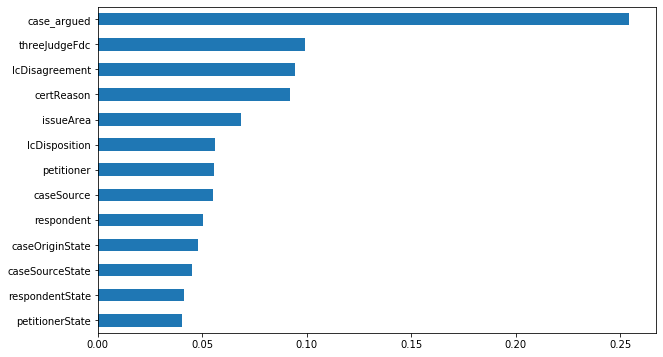

In [42]:
#Selected Feature Importances of the model from Random Forest Classifier
pd.Series(dict(zip(selected_features,xgboost.feature_importances_))).sort_values().plot(kind='barh',figsize=(10,6))

In [43]:
#Classification report for Test based on RandomForestClassifier
print(classification_report(y_val,rfc.predict(test[selected_features])))

              precision    recall  f1-score   support

           0       0.38      0.13      0.19       365
           1       0.64      0.88      0.74       635

    accuracy                           0.61      1000
   macro avg       0.51      0.50      0.46      1000
weighted avg       0.54      0.61      0.54      1000



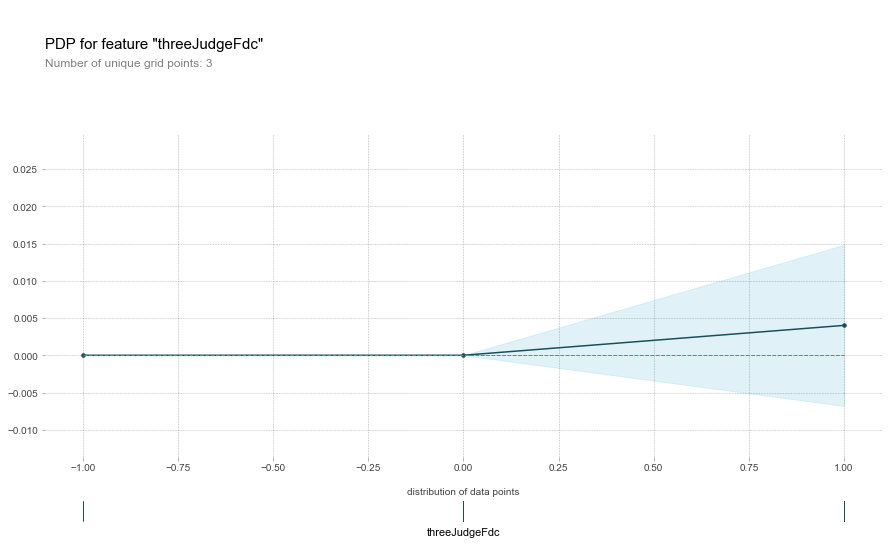

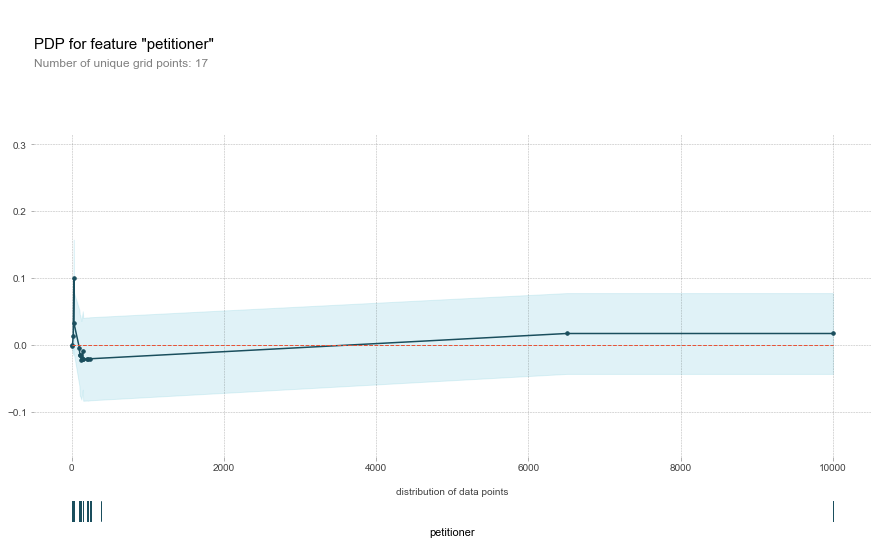

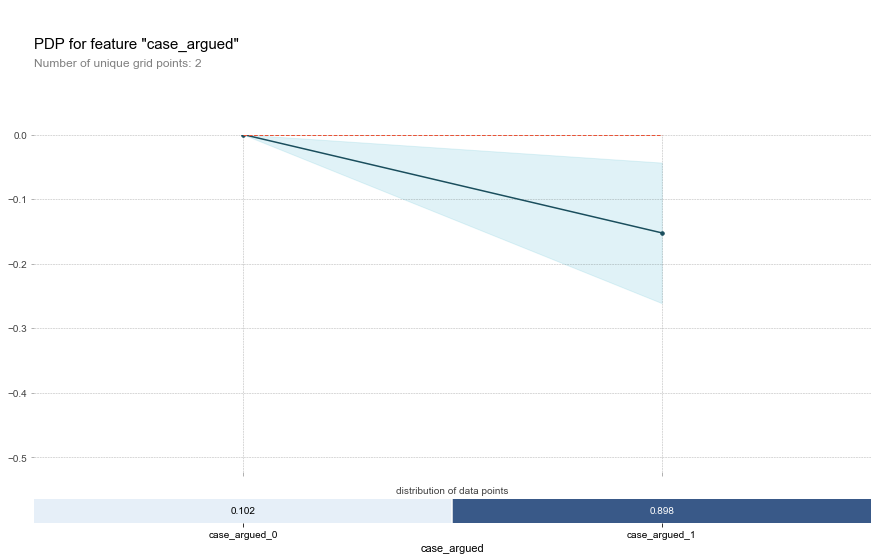

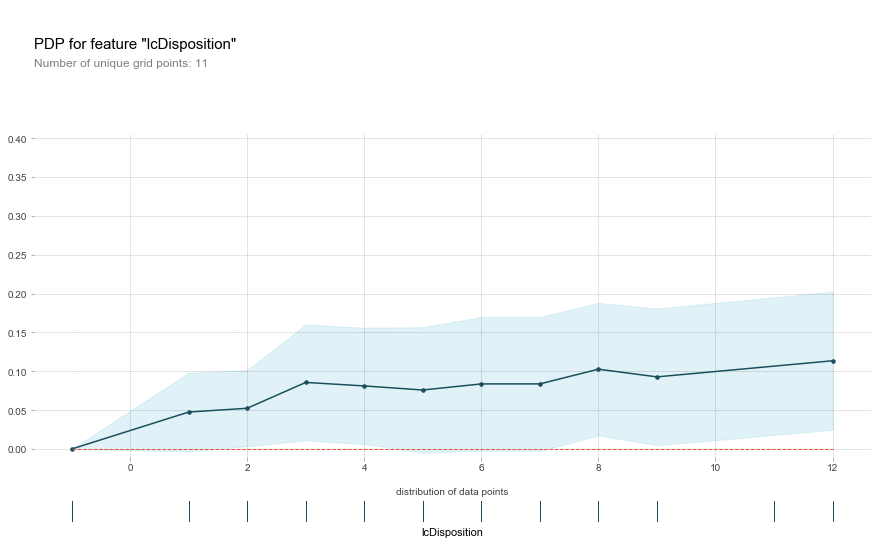

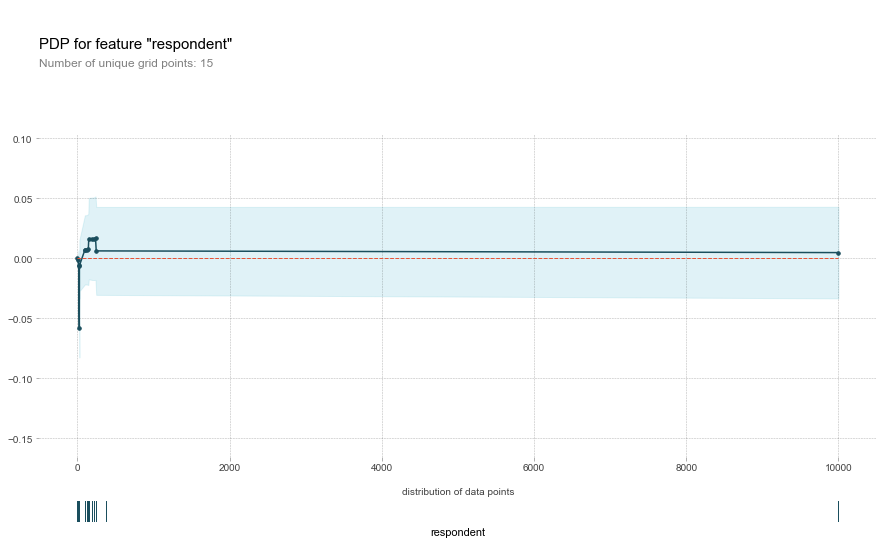

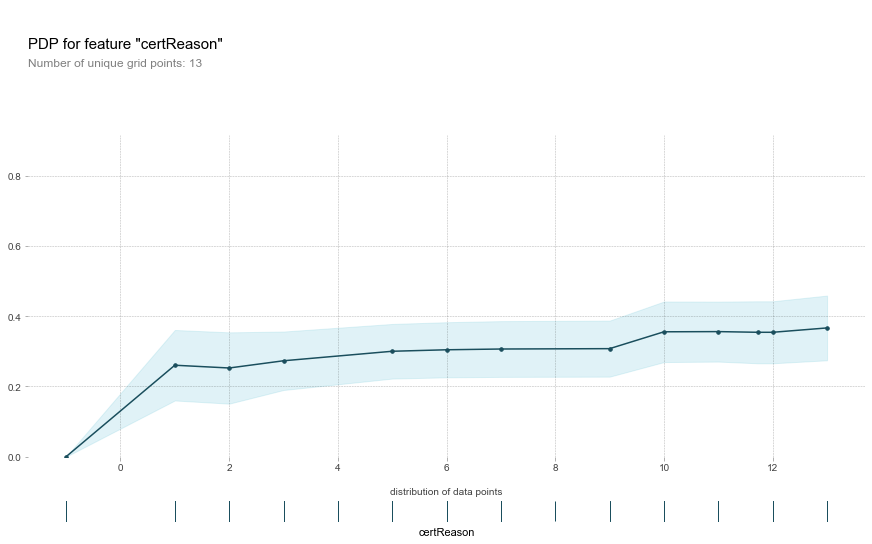

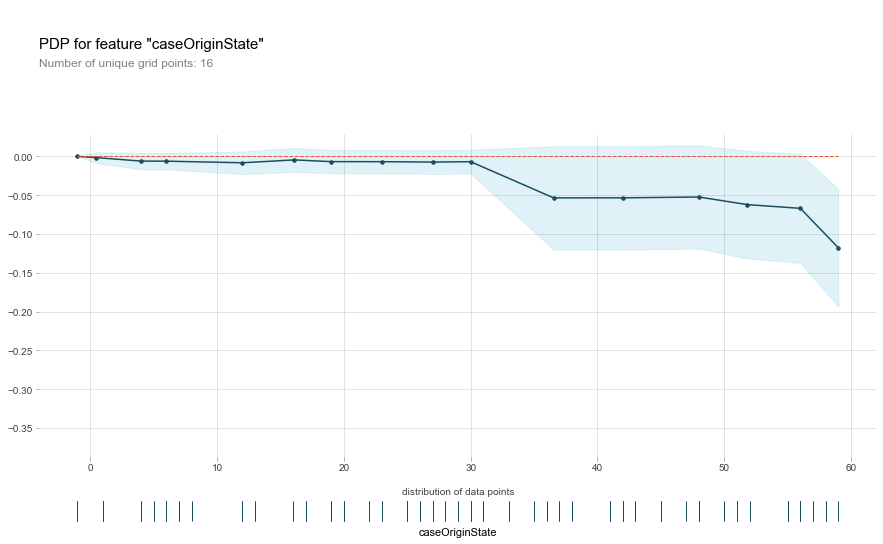

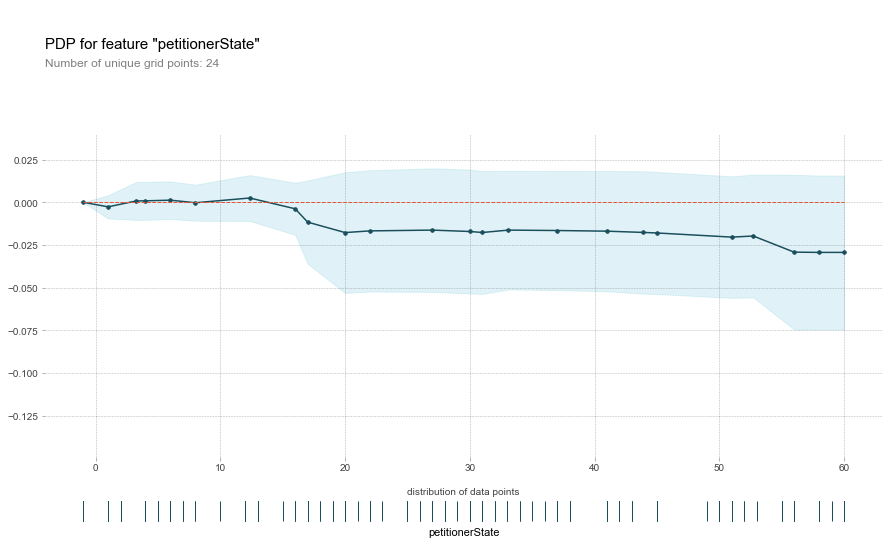

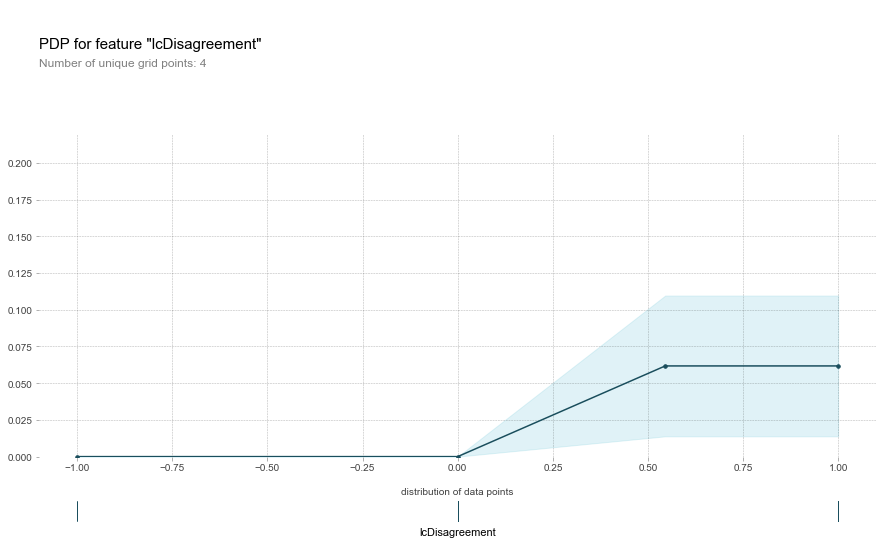

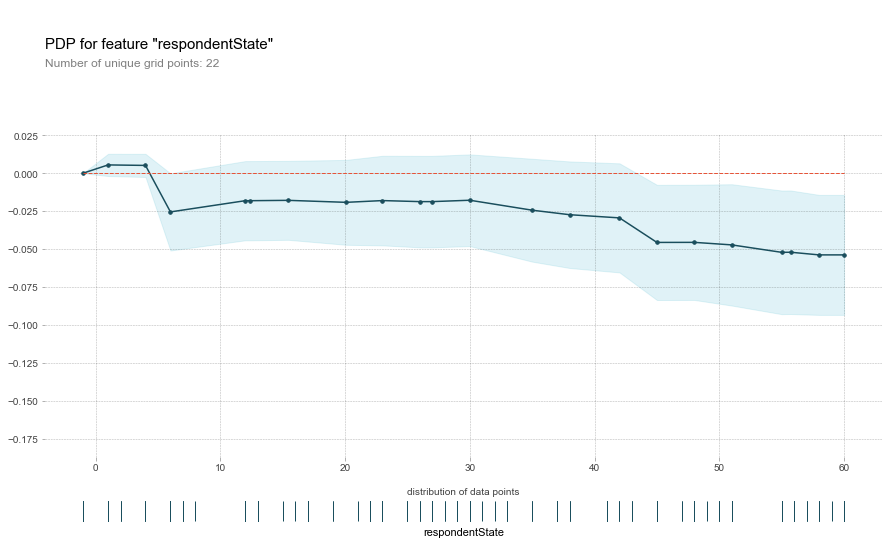

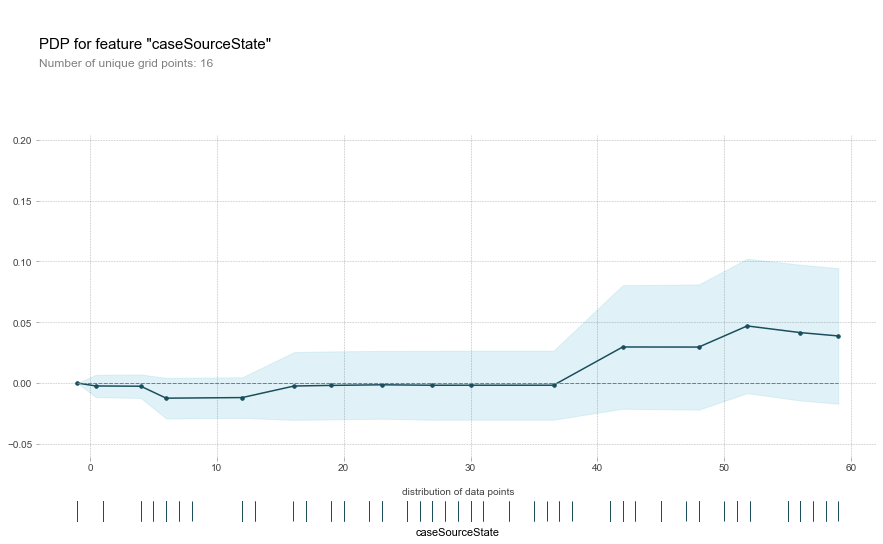

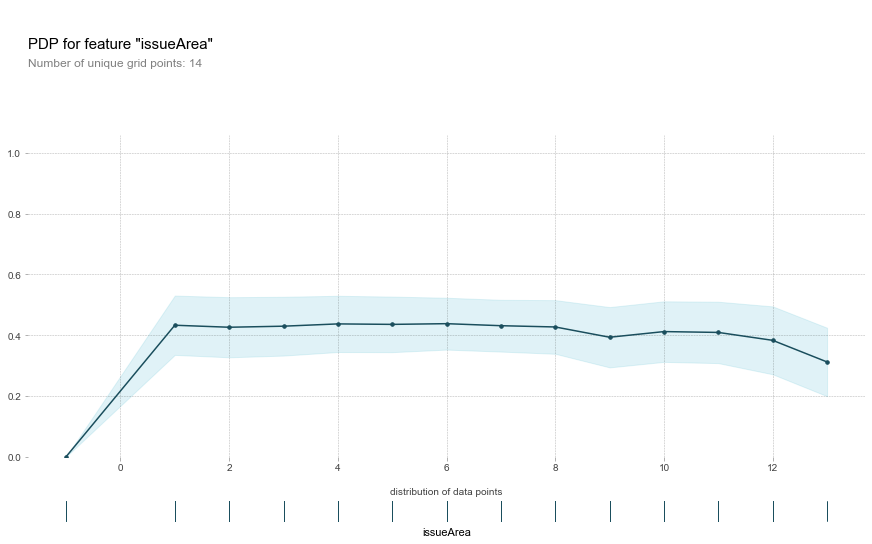

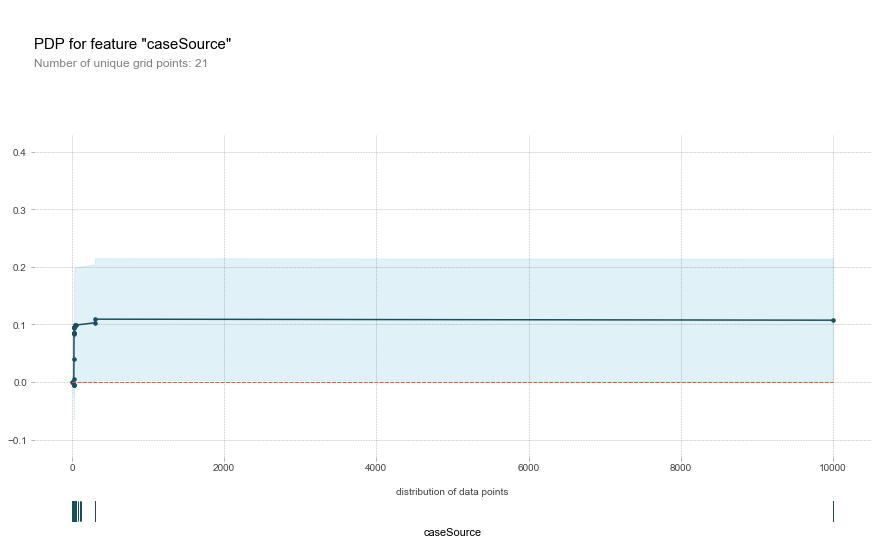

In [44]:
#Plotting pdp plot for each of the features
for f in selected_features:

    isolated = pdp_isolate(
    model=xgboost,
    dataset=val[selected_features],
    model_features=selected_features,
    feature=f,
    num_grid_points=100)

    pdp_plot(isolated,feature_name=f,plot_pts_dist=True)

In [45]:
import shap
explainer = shap.TreeExplainer(xgboost)
shap.initjs()

In [46]:
shap.force_plot(explainer.expected_value,explainer.shap_values(X_test.iloc[[2]][selected_features]),X_test.iloc[[2]][selected_features])


In [47]:
shap.force_plot(explainer.expected_value,explainer.shap_values(X_test.iloc[[3]][selected_features]),X_test.iloc[[3]][selected_features])


In [60]:
selected_features

['threeJudgeFdc',
 'petitioner',
 'case_argued',
 'lcDisposition',
 'respondent',
 'certReason',
 'caseOriginState',
 'petitionerState',
 'lcDisagreement',
 'respondentState',
 'caseSourceState',
 'issueArea',
 'caseSource']

In [48]:
fig = shap.force_plot(explainer.expected_value,explainer.shap_values(X_test.iloc[[3]][selected_features]),X_test.iloc[[3]][selected_features])


In [49]:
perm_xgboost = PermutationImportance(xgboost, random_state=1,scoring='roc_auc').fit(X_val[selected_features], y_val)
eli5.show_weights(perm_xgboost,feature_names=selected_features,top=None)

Weight,Feature
0.0264 ± 0.0255,certReason
0.0232 ± 0.0165,petitioner
0.0213 ± 0.0156,case_argued
0.0179 ± 0.0168,lcDisagreement
0.0155 ± 0.0054,respondent
0.0139 ± 0.0052,issueArea
0.0104 ± 0.0058,respondentState
0.0086 ± 0.0093,lcDisposition
0.0081 ± 0.0121,caseSource
0.0051 ± 0.0029,caseOriginState


In [50]:
X_train[selected_features].nunique()

threeJudgeFdc       3
petitioner         16
case_argued         2
lcDisposition      13
respondent         16
certReason         13
caseOriginState    53
petitionerState    57
lcDisagreement      3
respondentState    56
caseSourceState    53
issueArea          14
caseSource         34
dtype: int64

In [ ]:
isolated = pdp_isolate(
    model=xgboost,
    dataset=val[selected_features],
    model_features=selected_features,
    feature='argued_since',
    num_grid_points=100)
fig = pdp_plot(isolated,feature_name='argued_since',plot_pts_dist=True)

In [ ]:
len(features),len(selected_features)

In [51]:
from sklearn.metrics import roc_curve

In [52]:
thresholds,truepositive,falsepositive = roc_curve(y_test,xgboost.predict_proba(X_test[selected_features])[:,1])

In [53]:
falsepositive,truepositive,thresholds = roc_curve(y_test,xgboost.predict_proba(X_test[selected_features])[:,1])

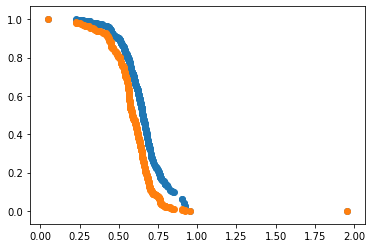

In [54]:
plt.scatter(thresholds,truepositive)
plt.scatter(thresholds,falsepositive)

Text(0, 0.5, 'True Positive Rate')

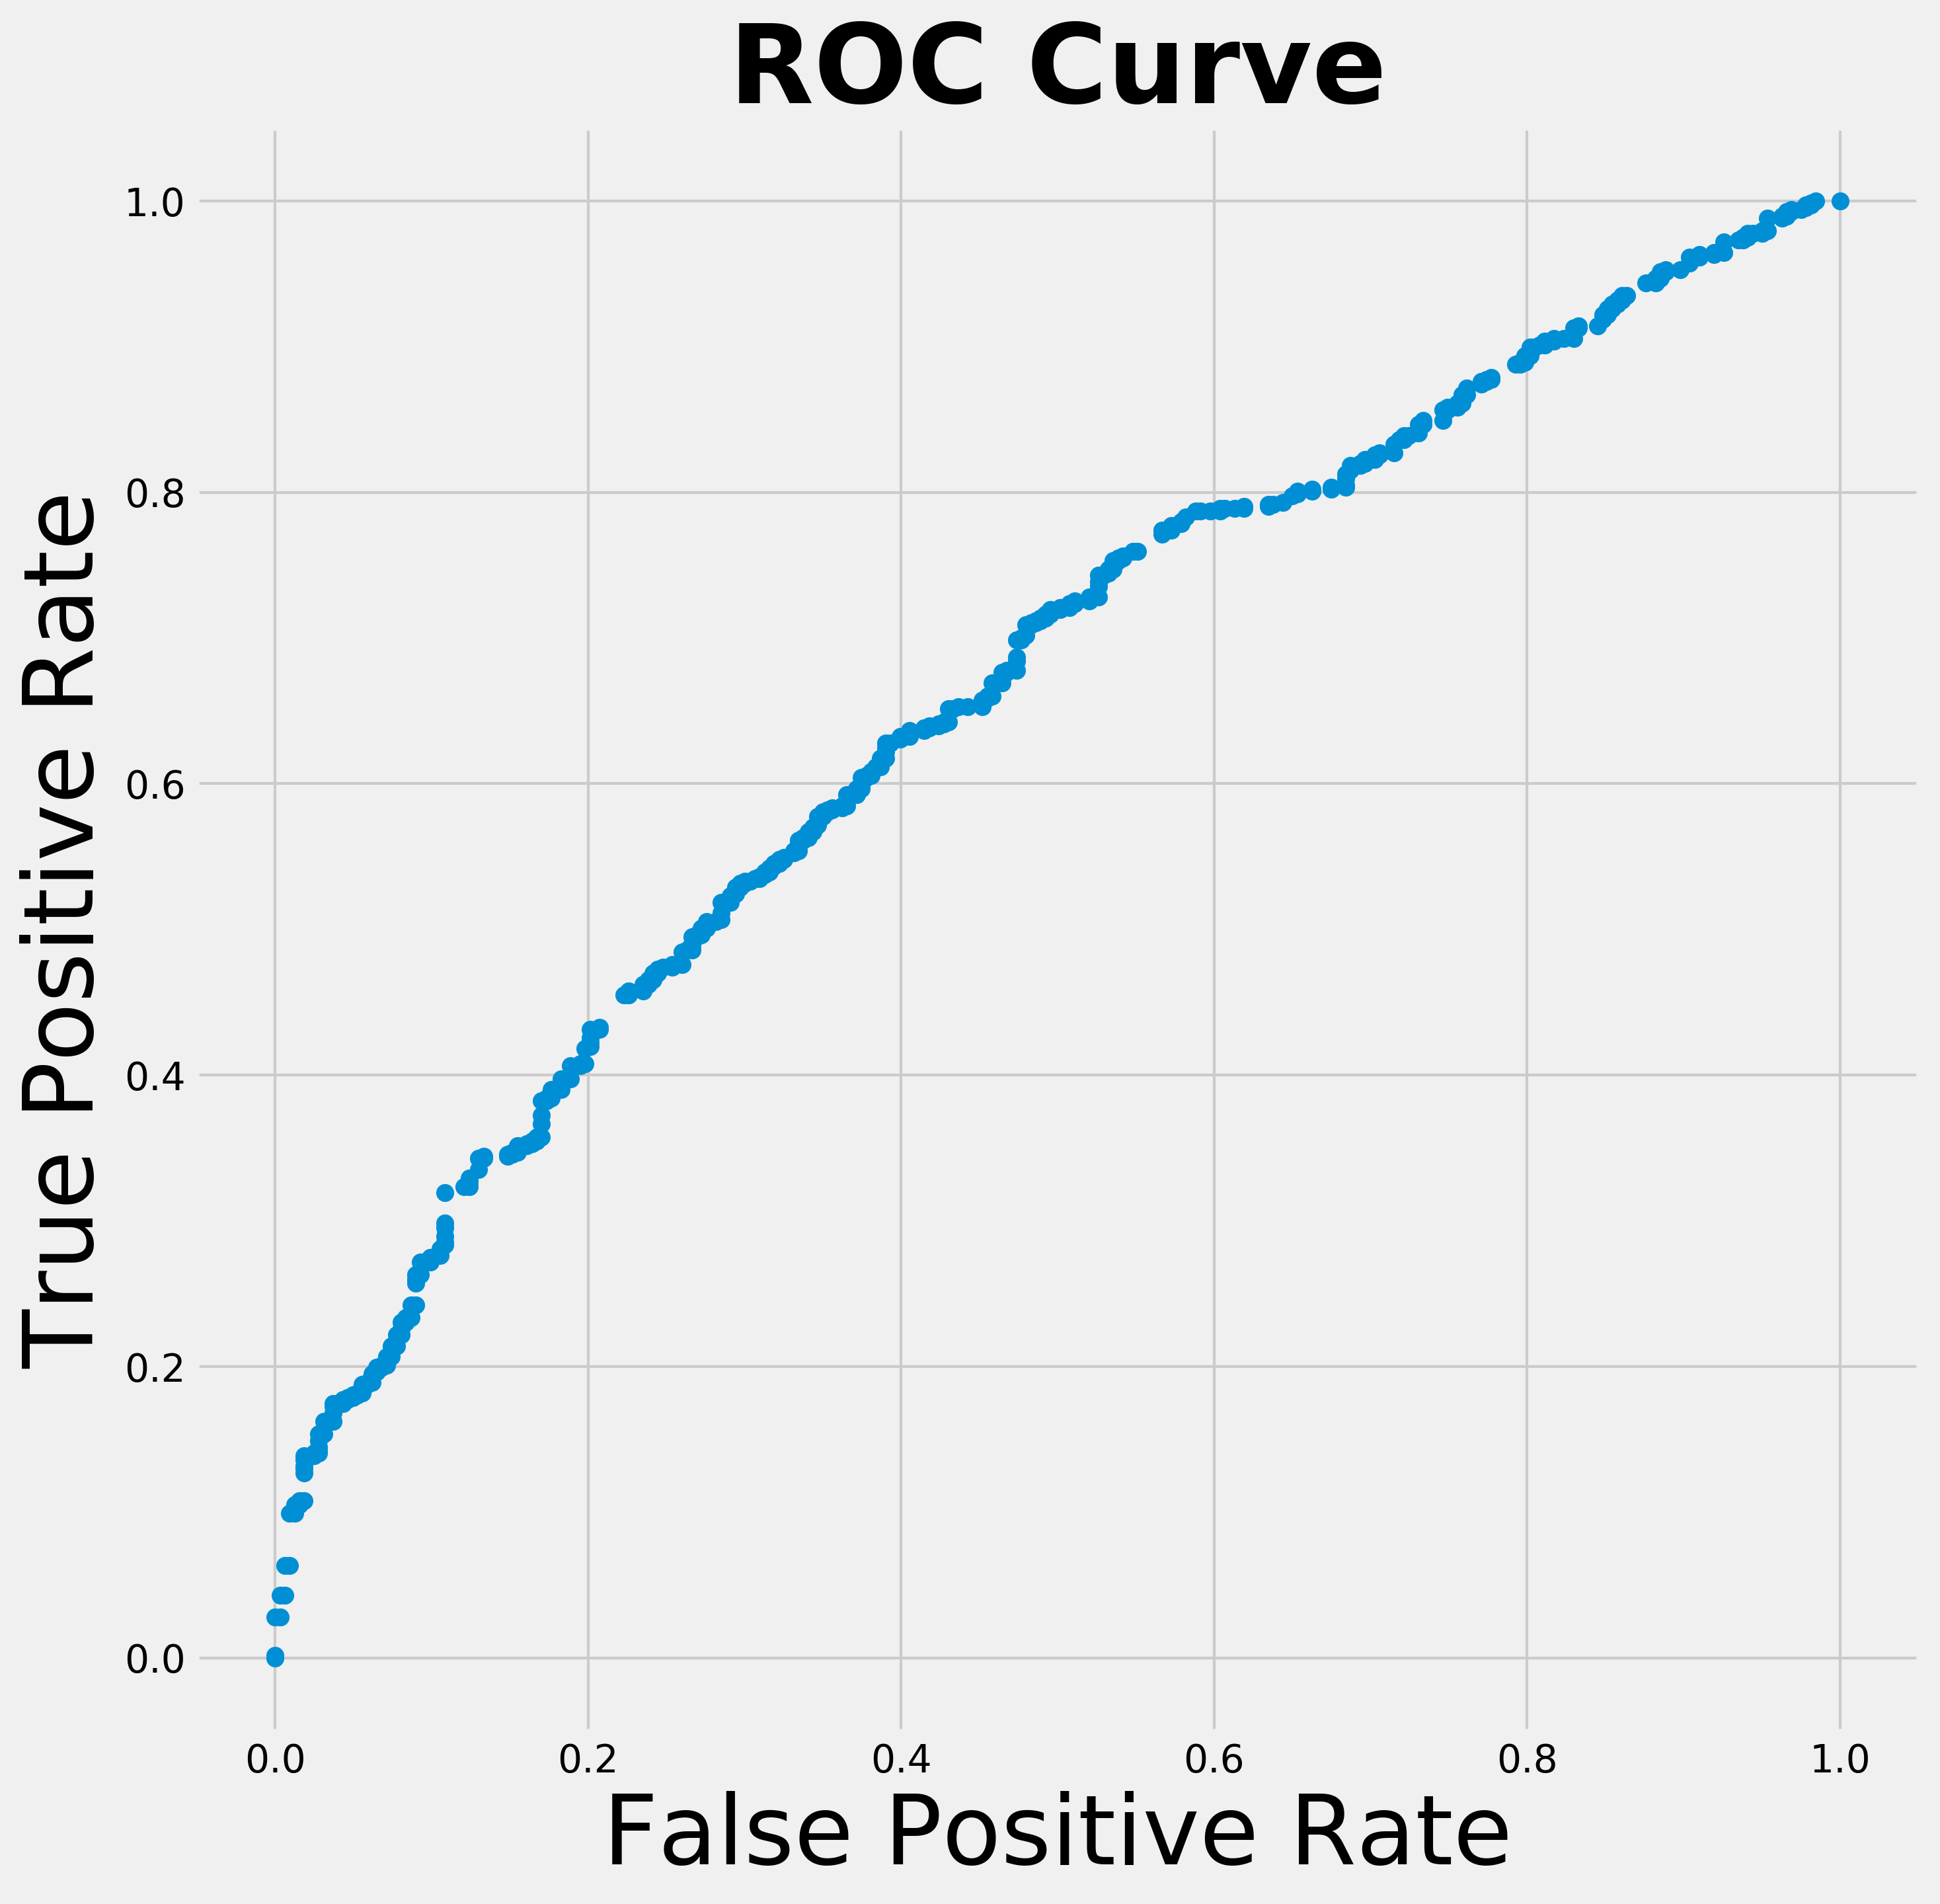

In [55]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(10,10),dpi=300)
plt.scatter(falsepositive,truepositive)
plt.title('ROC Curve', fontweight = 'bold', fontsize = 40)
plt.xlabel('False Positive Rate', fontsize = 35)
plt.ylabel('True Positive Rate', fontsize = 35)

In [56]:
#getting a test value for generating shap value
shaprow = X_test[selected_features].sample(1,random_state=5)
print("The probability of winning the case is ",xgboost.predict_proba(shaprow))

The probability of winning the case is  [[0.53572655 0.46427345]]


In [57]:
#Generating the shapvalue for the selected test row
shap.force_plot(explainer.expected_value,explainer.shap_values(shaprow),shaprow)

In [58]:
#Now, lets see the predicted probablit when the certReason is changed to 10
shaprow['certReason']=10
print("The probability of winning the case is ",xgboost.predict_proba(shaprow))

The probability of winning the case is  [[0.40187788 0.5981221 ]]


In [59]:
shap.force_plot(explainer.expected_value,explainer.shap_values(shaprow),shaprow)


In [62]:
from joblib import dump
dump(xgboost, '../assets/xgboost.joblib')

['../assets/xgboost.joblib']

In [65]:
shaprow

,threeJudgeFdc,petitioner,case_argued,lcDisposition,respondent,certReason,caseOriginState,petitionerState,lcDisagreement,respondentState,caseSourceState,issueArea,caseSource
8509,0,126,1,2,27,10,-1,-1,1,-1,-1,1,29


In [68]:
predict_data = pd.DataFrame(
    columns = ['threeJudgeFdc', 'petitioner', 'case_argued', 'lcDisposition', 'respondent', 
        'certReason', 'caseOriginState', 'petitionerState', 'lcDisagreement', 'respondentState',
         'caseSourceState', 'issueArea', 'caseSource'],
    #Hard coding threejudgefdc, need to get the input later
    data = [[1, 28, 0, 1, 126, 8, -1, -1, 1, -1, -1, 1, 28]]
         )

In [69]:
xgboost.predict_proba(predict_data)

array([[0.16326028, 0.8367397 ]], dtype=float32)

In [64]:
features

['petitioner',
 'petitionerState',
 'respondent',
 'respondentState',
 'jurisdiction',
 'threeJudgeFdc',
 'caseOrigin',
 'caseOriginState',
 'caseSource',
 'caseSourceState',
 'lcDisagreement',
 'certReason',
 'lcDisposition',
 'issueArea',
 'case_argued',
 'case_reargued',
 'is_adminAction',
 'is_adminActionState']

In [63]:
selected_features

['threeJudgeFdc',
 'petitioner',
 'case_argued',
 'lcDisposition',
 'respondent',
 'certReason',
 'caseOriginState',
 'petitionerState',
 'lcDisagreement',
 'respondentState',
 'caseSourceState',
 'issueArea',
 'caseSource']

In [ ]:
#ax.savefig('../assets/partialplot',dpi=172)